# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

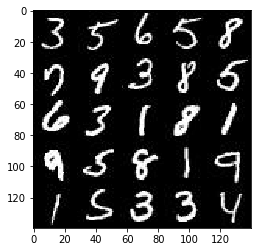

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

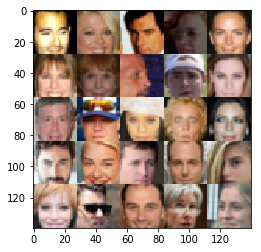

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, [None, z_dim], name='inputs_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return inputs_real, inputs_z, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [38]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    alpha = 0.2
    keep_prob = 0.5
    
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # Input layer is 28x28x3
        # Don't use batch norm on the first layer as per Matt
        
        x0 = tf.layers.conv2d(images, 32, 5, strides=2, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = tf.maximum(alpha * x0, x0)
        
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn1 = tf.layers.batch_normalization(x1, training=True)
        relu1 = tf.maximum(alpha * bn1, bn1)
        dropx1 = tf.nn.dropout(relu1, keep_prob)
        
        x2 = tf.layers.conv2d(dropx1, 128, 5, strides=2, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        dropx2 = tf.nn.dropout(relu2, keep_prob)
        
        x3 = tf.layers.conv2d(dropx2, 256, 5, strides=2, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        
        # Flatten it into one long vector
        flat = tf.reshape(relu3, (-1, 2*2*256))
        logits = tf.layers.dense(flat, 1, activation=None)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [39]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    alpha = 0.2
    keep_prob = 0.5    
    
    with tf.variable_scope('generator', reuse=not is_train):
        
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*512)
        
        # Reshape it to start the convolutional stack
        # 1.) Transpose convolution
        # 2.) Batch norm
        # 3.) Activation - Leaky ReLu      
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 4, strides=1, padding='valid',kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)     

        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        x4 = tf.layers.conv2d_transpose(x3, 32, 5, strides=2, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 3, strides=1, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        
        out = tf.tanh(logits)
        # generated image being output
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [40]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
                  tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                          labels=tf.ones_like(d_model_real) * (1 - smooth)))                                                         
    d_loss_fake = tf.reduce_mean(
                  tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                          labels=tf.zeros_like(d_model_fake)))


    g_loss = tf.reduce_mean(
             tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                     labels=tf.ones_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss   

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [41]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [42]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [43]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1) 

    
    # TODO: Train Model
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epoch_count):
            steps = 0
            
            for batch_images in get_batches(batch_size):
                
                steps += 1                            
                # Need to scale these values
                batch_images = batch_images * 2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})

          
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(e+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if steps % 100 == 0:  
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.6300... Generator Loss: 3.1720
Epoch 1/2... Discriminator Loss: 1.8758... Generator Loss: 1.4169
Epoch 1/2... Discriminator Loss: 1.5937... Generator Loss: 1.6414
Epoch 1/2... Discriminator Loss: 1.4222... Generator Loss: 1.5073
Epoch 1/2... Discriminator Loss: 1.8968... Generator Loss: 0.3985
Epoch 1/2... Discriminator Loss: 1.4678... Generator Loss: 0.6125
Epoch 1/2... Discriminator Loss: 1.3684... Generator Loss: 0.7492
Epoch 1/2... Discriminator Loss: 1.4452... Generator Loss: 0.6053
Epoch 1/2... Discriminator Loss: 1.4470... Generator Loss: 0.6128
Epoch 1/2... Discriminator Loss: 1.5525... Generator Loss: 0.6236


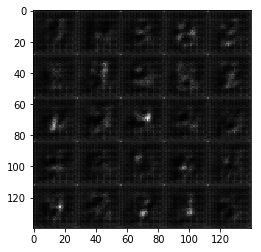

Epoch 1/2... Discriminator Loss: 1.3658... Generator Loss: 0.7248
Epoch 1/2... Discriminator Loss: 1.3522... Generator Loss: 0.8834
Epoch 1/2... Discriminator Loss: 1.3918... Generator Loss: 0.6848
Epoch 1/2... Discriminator Loss: 1.3913... Generator Loss: 0.7374
Epoch 1/2... Discriminator Loss: 1.3170... Generator Loss: 0.8087
Epoch 1/2... Discriminator Loss: 1.3920... Generator Loss: 0.8439
Epoch 1/2... Discriminator Loss: 1.4147... Generator Loss: 1.1385
Epoch 1/2... Discriminator Loss: 1.4100... Generator Loss: 0.9947
Epoch 1/2... Discriminator Loss: 1.3293... Generator Loss: 0.8680
Epoch 1/2... Discriminator Loss: 1.3262... Generator Loss: 0.7503


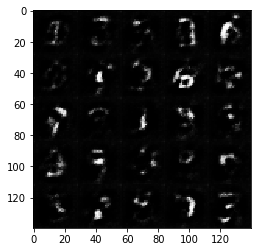

Epoch 1/2... Discriminator Loss: 1.3880... Generator Loss: 0.6496
Epoch 1/2... Discriminator Loss: 1.3719... Generator Loss: 0.6755
Epoch 1/2... Discriminator Loss: 1.4041... Generator Loss: 0.6617
Epoch 1/2... Discriminator Loss: 1.3828... Generator Loss: 0.8337
Epoch 1/2... Discriminator Loss: 1.3541... Generator Loss: 0.9982
Epoch 1/2... Discriminator Loss: 1.4195... Generator Loss: 1.1128
Epoch 1/2... Discriminator Loss: 1.3137... Generator Loss: 0.8845
Epoch 1/2... Discriminator Loss: 1.2947... Generator Loss: 1.0077
Epoch 1/2... Discriminator Loss: 1.4006... Generator Loss: 1.0047
Epoch 1/2... Discriminator Loss: 1.3657... Generator Loss: 0.8283


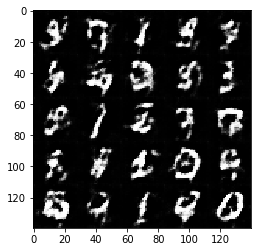

Epoch 1/2... Discriminator Loss: 1.4068... Generator Loss: 1.0444
Epoch 1/2... Discriminator Loss: 1.3668... Generator Loss: 1.0036
Epoch 1/2... Discriminator Loss: 1.3795... Generator Loss: 1.0463
Epoch 1/2... Discriminator Loss: 1.3609... Generator Loss: 0.9503
Epoch 1/2... Discriminator Loss: 1.2903... Generator Loss: 1.0465
Epoch 1/2... Discriminator Loss: 1.3820... Generator Loss: 0.9352
Epoch 1/2... Discriminator Loss: 1.4498... Generator Loss: 1.3705
Epoch 1/2... Discriminator Loss: 1.3300... Generator Loss: 0.8621
Epoch 1/2... Discriminator Loss: 1.3616... Generator Loss: 0.8853
Epoch 1/2... Discriminator Loss: 1.3620... Generator Loss: 0.7122


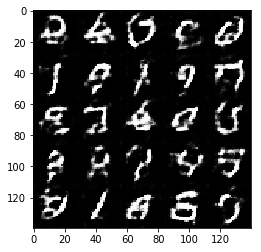

Epoch 1/2... Discriminator Loss: 1.3849... Generator Loss: 0.8093
Epoch 1/2... Discriminator Loss: 1.3586... Generator Loss: 0.9265
Epoch 1/2... Discriminator Loss: 1.3671... Generator Loss: 0.9437
Epoch 1/2... Discriminator Loss: 1.4035... Generator Loss: 0.5908
Epoch 1/2... Discriminator Loss: 1.3835... Generator Loss: 0.7199
Epoch 1/2... Discriminator Loss: 1.3847... Generator Loss: 0.7513
Epoch 1/2... Discriminator Loss: 1.3760... Generator Loss: 0.6213
Epoch 1/2... Discriminator Loss: 1.3527... Generator Loss: 0.7662
Epoch 1/2... Discriminator Loss: 1.3302... Generator Loss: 0.7791
Epoch 1/2... Discriminator Loss: 1.3084... Generator Loss: 0.8105


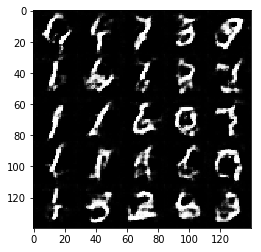

Epoch 1/2... Discriminator Loss: 1.3463... Generator Loss: 0.6477
Epoch 1/2... Discriminator Loss: 1.3616... Generator Loss: 0.7070
Epoch 1/2... Discriminator Loss: 1.3490... Generator Loss: 0.8855
Epoch 1/2... Discriminator Loss: 1.3999... Generator Loss: 0.9562
Epoch 1/2... Discriminator Loss: 1.3332... Generator Loss: 0.8639
Epoch 1/2... Discriminator Loss: 1.3339... Generator Loss: 0.8352
Epoch 1/2... Discriminator Loss: 1.3474... Generator Loss: 0.7876
Epoch 1/2... Discriminator Loss: 1.4334... Generator Loss: 0.5554
Epoch 1/2... Discriminator Loss: 1.3661... Generator Loss: 0.7958
Epoch 1/2... Discriminator Loss: 1.3438... Generator Loss: 0.7931


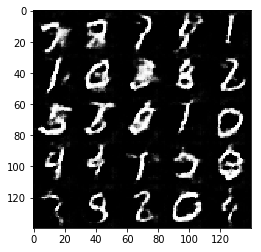

Epoch 1/2... Discriminator Loss: 1.4286... Generator Loss: 0.6987
Epoch 1/2... Discriminator Loss: 1.3569... Generator Loss: 0.7283
Epoch 1/2... Discriminator Loss: 1.3830... Generator Loss: 0.6574
Epoch 1/2... Discriminator Loss: 1.3473... Generator Loss: 0.6159
Epoch 1/2... Discriminator Loss: 1.3522... Generator Loss: 0.7361
Epoch 1/2... Discriminator Loss: 1.3635... Generator Loss: 0.7719
Epoch 1/2... Discriminator Loss: 1.3352... Generator Loss: 0.9199
Epoch 1/2... Discriminator Loss: 1.4170... Generator Loss: 1.0536
Epoch 1/2... Discriminator Loss: 1.3134... Generator Loss: 0.8663
Epoch 1/2... Discriminator Loss: 1.3716... Generator Loss: 0.7934


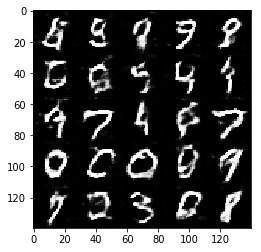

Epoch 1/2... Discriminator Loss: 1.4304... Generator Loss: 0.6025
Epoch 1/2... Discriminator Loss: 1.3467... Generator Loss: 0.7494
Epoch 1/2... Discriminator Loss: 1.3613... Generator Loss: 0.6950
Epoch 1/2... Discriminator Loss: 1.3438... Generator Loss: 0.6927
Epoch 1/2... Discriminator Loss: 1.4019... Generator Loss: 0.7258
Epoch 1/2... Discriminator Loss: 1.3216... Generator Loss: 0.8051
Epoch 1/2... Discriminator Loss: 1.3715... Generator Loss: 0.7546
Epoch 1/2... Discriminator Loss: 1.3627... Generator Loss: 0.6480
Epoch 1/2... Discriminator Loss: 1.3498... Generator Loss: 0.9046
Epoch 1/2... Discriminator Loss: 1.2780... Generator Loss: 0.9402


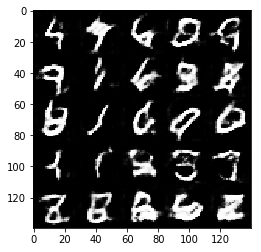

Epoch 1/2... Discriminator Loss: 1.3214... Generator Loss: 0.8818
Epoch 1/2... Discriminator Loss: 1.3509... Generator Loss: 1.0312
Epoch 1/2... Discriminator Loss: 1.3466... Generator Loss: 0.6819
Epoch 1/2... Discriminator Loss: 1.4184... Generator Loss: 0.6769
Epoch 1/2... Discriminator Loss: 1.3402... Generator Loss: 0.9270
Epoch 1/2... Discriminator Loss: 1.2976... Generator Loss: 0.8829
Epoch 1/2... Discriminator Loss: 1.3450... Generator Loss: 0.9098
Epoch 1/2... Discriminator Loss: 1.4028... Generator Loss: 1.1806
Epoch 1/2... Discriminator Loss: 1.3110... Generator Loss: 0.9263
Epoch 1/2... Discriminator Loss: 1.2961... Generator Loss: 0.8669


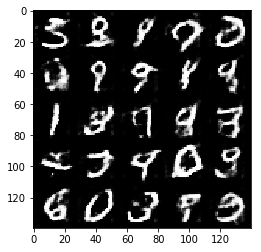

Epoch 1/2... Discriminator Loss: 1.3267... Generator Loss: 0.7551
Epoch 1/2... Discriminator Loss: 1.3915... Generator Loss: 0.5971
Epoch 1/2... Discriminator Loss: 1.3509... Generator Loss: 0.7741
Epoch 2/2... Discriminator Loss: 1.3143... Generator Loss: 0.9524
Epoch 2/2... Discriminator Loss: 1.3148... Generator Loss: 0.8924
Epoch 2/2... Discriminator Loss: 1.3345... Generator Loss: 0.8016
Epoch 2/2... Discriminator Loss: 1.3668... Generator Loss: 0.6653
Epoch 2/2... Discriminator Loss: 1.3649... Generator Loss: 0.6948
Epoch 2/2... Discriminator Loss: 1.3418... Generator Loss: 1.0592
Epoch 2/2... Discriminator Loss: 1.3413... Generator Loss: 1.0009
Epoch 2/2... Discriminator Loss: 1.3220... Generator Loss: 0.7990
Epoch 2/2... Discriminator Loss: 1.4281... Generator Loss: 1.0997
Epoch 2/2... Discriminator Loss: 1.3355... Generator Loss: 0.8970


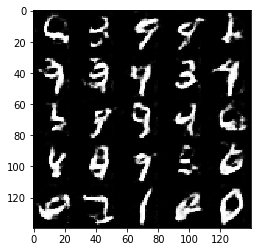

Epoch 2/2... Discriminator Loss: 1.2874... Generator Loss: 0.9550
Epoch 2/2... Discriminator Loss: 1.3017... Generator Loss: 0.8217
Epoch 2/2... Discriminator Loss: 1.3054... Generator Loss: 0.9317
Epoch 2/2... Discriminator Loss: 1.3464... Generator Loss: 1.0566
Epoch 2/2... Discriminator Loss: 1.3391... Generator Loss: 0.8676
Epoch 2/2... Discriminator Loss: 1.3809... Generator Loss: 0.6454
Epoch 2/2... Discriminator Loss: 1.3509... Generator Loss: 0.9181
Epoch 2/2... Discriminator Loss: 1.3273... Generator Loss: 0.7879
Epoch 2/2... Discriminator Loss: 1.3012... Generator Loss: 0.8052
Epoch 2/2... Discriminator Loss: 1.3735... Generator Loss: 0.6706


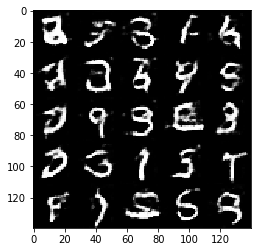

Epoch 2/2... Discriminator Loss: 1.3234... Generator Loss: 0.7584
Epoch 2/2... Discriminator Loss: 1.3462... Generator Loss: 0.7279
Epoch 2/2... Discriminator Loss: 1.3458... Generator Loss: 0.8467
Epoch 2/2... Discriminator Loss: 1.3474... Generator Loss: 0.9733
Epoch 2/2... Discriminator Loss: 1.3421... Generator Loss: 1.0421
Epoch 2/2... Discriminator Loss: 1.3489... Generator Loss: 0.9899
Epoch 2/2... Discriminator Loss: 1.3172... Generator Loss: 0.8538
Epoch 2/2... Discriminator Loss: 1.2955... Generator Loss: 0.7828
Epoch 2/2... Discriminator Loss: 1.3335... Generator Loss: 0.6566
Epoch 2/2... Discriminator Loss: 1.3910... Generator Loss: 0.6865


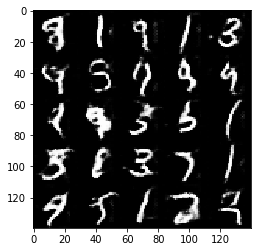

Epoch 2/2... Discriminator Loss: 1.3360... Generator Loss: 1.0406
Epoch 2/2... Discriminator Loss: 1.2874... Generator Loss: 0.9435
Epoch 2/2... Discriminator Loss: 1.2979... Generator Loss: 0.9396
Epoch 2/2... Discriminator Loss: 1.3455... Generator Loss: 0.8100
Epoch 2/2... Discriminator Loss: 1.3381... Generator Loss: 0.9408
Epoch 2/2... Discriminator Loss: 1.3270... Generator Loss: 0.7762
Epoch 2/2... Discriminator Loss: 1.3892... Generator Loss: 0.7282
Epoch 2/2... Discriminator Loss: 1.2742... Generator Loss: 0.8031
Epoch 2/2... Discriminator Loss: 1.3719... Generator Loss: 1.2298
Epoch 2/2... Discriminator Loss: 1.3484... Generator Loss: 0.9333


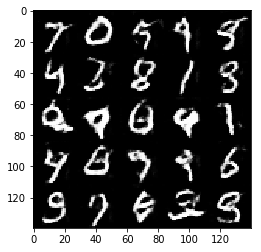

Epoch 2/2... Discriminator Loss: 1.3768... Generator Loss: 0.9240
Epoch 2/2... Discriminator Loss: 1.2959... Generator Loss: 1.0624
Epoch 2/2... Discriminator Loss: 1.2752... Generator Loss: 0.8776
Epoch 2/2... Discriminator Loss: 1.3548... Generator Loss: 0.8433
Epoch 2/2... Discriminator Loss: 1.4426... Generator Loss: 0.5768
Epoch 2/2... Discriminator Loss: 1.3682... Generator Loss: 0.7725
Epoch 2/2... Discriminator Loss: 1.3606... Generator Loss: 0.9300
Epoch 2/2... Discriminator Loss: 1.3854... Generator Loss: 0.6907
Epoch 2/2... Discriminator Loss: 1.3598... Generator Loss: 0.6589
Epoch 2/2... Discriminator Loss: 1.3688... Generator Loss: 0.7017


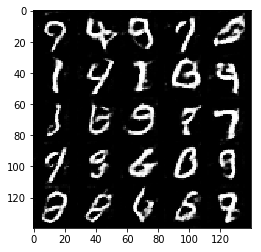

Epoch 2/2... Discriminator Loss: 1.3167... Generator Loss: 0.8633
Epoch 2/2... Discriminator Loss: 1.2860... Generator Loss: 0.8545
Epoch 2/2... Discriminator Loss: 1.3533... Generator Loss: 0.7329
Epoch 2/2... Discriminator Loss: 1.3697... Generator Loss: 0.6395
Epoch 2/2... Discriminator Loss: 1.3325... Generator Loss: 0.7719
Epoch 2/2... Discriminator Loss: 1.3415... Generator Loss: 0.8785
Epoch 2/2... Discriminator Loss: 1.2742... Generator Loss: 0.8235
Epoch 2/2... Discriminator Loss: 1.3415... Generator Loss: 0.8294
Epoch 2/2... Discriminator Loss: 1.3607... Generator Loss: 0.7753
Epoch 2/2... Discriminator Loss: 1.2993... Generator Loss: 0.9432


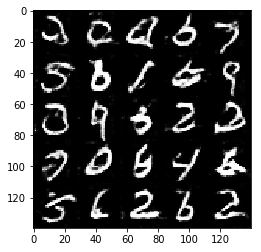

Epoch 2/2... Discriminator Loss: 1.3989... Generator Loss: 0.6929
Epoch 2/2... Discriminator Loss: 1.3685... Generator Loss: 0.7139
Epoch 2/2... Discriminator Loss: 1.3362... Generator Loss: 0.9410
Epoch 2/2... Discriminator Loss: 1.3095... Generator Loss: 0.9636
Epoch 2/2... Discriminator Loss: 1.3357... Generator Loss: 0.8478
Epoch 2/2... Discriminator Loss: 1.3182... Generator Loss: 1.1429
Epoch 2/2... Discriminator Loss: 1.3864... Generator Loss: 0.8886
Epoch 2/2... Discriminator Loss: 1.2887... Generator Loss: 0.9445
Epoch 2/2... Discriminator Loss: 1.3215... Generator Loss: 0.8070
Epoch 2/2... Discriminator Loss: 1.2851... Generator Loss: 0.8206


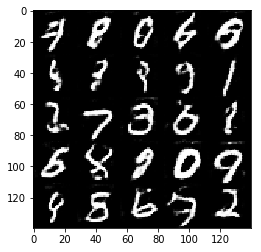

Epoch 2/2... Discriminator Loss: 1.3541... Generator Loss: 0.7826
Epoch 2/2... Discriminator Loss: 1.2997... Generator Loss: 0.8238
Epoch 2/2... Discriminator Loss: 1.3272... Generator Loss: 1.1241
Epoch 2/2... Discriminator Loss: 1.3284... Generator Loss: 0.6964
Epoch 2/2... Discriminator Loss: 1.3073... Generator Loss: 0.8031
Epoch 2/2... Discriminator Loss: 1.3267... Generator Loss: 0.7831
Epoch 2/2... Discriminator Loss: 1.3822... Generator Loss: 0.8316
Epoch 2/2... Discriminator Loss: 1.3530... Generator Loss: 0.9259
Epoch 2/2... Discriminator Loss: 1.2895... Generator Loss: 0.7793
Epoch 2/2... Discriminator Loss: 1.3390... Generator Loss: 0.9515


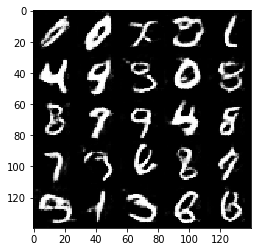

Epoch 2/2... Discriminator Loss: 1.3930... Generator Loss: 0.6163
Epoch 2/2... Discriminator Loss: 1.3723... Generator Loss: 0.6427
Epoch 2/2... Discriminator Loss: 1.2758... Generator Loss: 0.7088
Epoch 2/2... Discriminator Loss: 1.3421... Generator Loss: 0.9979
Epoch 2/2... Discriminator Loss: 1.2984... Generator Loss: 0.9548
Epoch 2/2... Discriminator Loss: 1.3577... Generator Loss: 1.0102
Epoch 2/2... Discriminator Loss: 1.3167... Generator Loss: 1.0045
Epoch 2/2... Discriminator Loss: 1.3392... Generator Loss: 0.8590
Epoch 2/2... Discriminator Loss: 1.3690... Generator Loss: 0.6667
Epoch 2/2... Discriminator Loss: 1.3650... Generator Loss: 0.9336


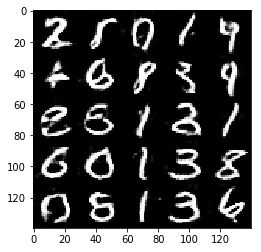

Epoch 2/2... Discriminator Loss: 1.2625... Generator Loss: 0.9332
Epoch 2/2... Discriminator Loss: 1.4004... Generator Loss: 0.6918
Epoch 2/2... Discriminator Loss: 1.3475... Generator Loss: 0.9677


In [44]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.4263... Generator Loss: 2.7403
Epoch 1/1... Discriminator Loss: 1.1013... Generator Loss: 2.0612
Epoch 1/1... Discriminator Loss: 1.2849... Generator Loss: 2.4163
Epoch 1/1... Discriminator Loss: 1.2782... Generator Loss: 3.0182
Epoch 1/1... Discriminator Loss: 1.1444... Generator Loss: 2.2925
Epoch 1/1... Discriminator Loss: 1.0023... Generator Loss: 1.8221
Epoch 1/1... Discriminator Loss: 1.4069... Generator Loss: 3.6030
Epoch 1/1... Discriminator Loss: 1.3601... Generator Loss: 2.7945
Epoch 1/1... Discriminator Loss: 0.8990... Generator Loss: 1.9153
Epoch 1/1... Discriminator Loss: 0.7824... Generator Loss: 1.7278


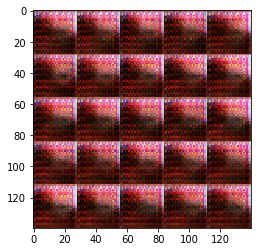

Epoch 1/1... Discriminator Loss: 0.8730... Generator Loss: 2.0733
Epoch 1/1... Discriminator Loss: 0.9611... Generator Loss: 2.3267
Epoch 1/1... Discriminator Loss: 1.4800... Generator Loss: 0.7050
Epoch 1/1... Discriminator Loss: 1.2663... Generator Loss: 0.8590
Epoch 1/1... Discriminator Loss: 1.4232... Generator Loss: 1.1115
Epoch 1/1... Discriminator Loss: 1.3185... Generator Loss: 0.8380
Epoch 1/1... Discriminator Loss: 1.2749... Generator Loss: 0.8133
Epoch 1/1... Discriminator Loss: 1.1288... Generator Loss: 1.0573
Epoch 1/1... Discriminator Loss: 1.2992... Generator Loss: 0.6714
Epoch 1/1... Discriminator Loss: 1.3346... Generator Loss: 0.9441


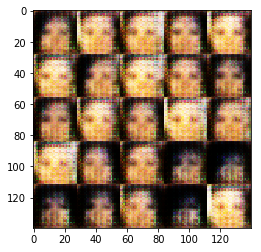

Epoch 1/1... Discriminator Loss: 1.1892... Generator Loss: 0.9084
Epoch 1/1... Discriminator Loss: 1.2457... Generator Loss: 1.4850
Epoch 1/1... Discriminator Loss: 1.4386... Generator Loss: 1.0460
Epoch 1/1... Discriminator Loss: 1.5147... Generator Loss: 1.0302
Epoch 1/1... Discriminator Loss: 1.2851... Generator Loss: 1.1044
Epoch 1/1... Discriminator Loss: 1.0897... Generator Loss: 1.2821
Epoch 1/1... Discriminator Loss: 1.2136... Generator Loss: 1.7324
Epoch 1/1... Discriminator Loss: 1.1629... Generator Loss: 1.8096
Epoch 1/1... Discriminator Loss: 1.4154... Generator Loss: 0.7972
Epoch 1/1... Discriminator Loss: 1.4779... Generator Loss: 0.5604


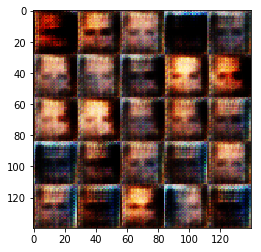

Epoch 1/1... Discriminator Loss: 1.3610... Generator Loss: 1.7652
Epoch 1/1... Discriminator Loss: 1.0490... Generator Loss: 1.1925
Epoch 1/1... Discriminator Loss: 1.2918... Generator Loss: 0.9039
Epoch 1/1... Discriminator Loss: 1.1607... Generator Loss: 1.1368
Epoch 1/1... Discriminator Loss: 1.5609... Generator Loss: 1.0422
Epoch 1/1... Discriminator Loss: 1.1732... Generator Loss: 0.9881
Epoch 1/1... Discriminator Loss: 1.4643... Generator Loss: 1.1224
Epoch 1/1... Discriminator Loss: 1.3354... Generator Loss: 1.3002
Epoch 1/1... Discriminator Loss: 1.1492... Generator Loss: 1.0358
Epoch 1/1... Discriminator Loss: 1.3571... Generator Loss: 0.7153


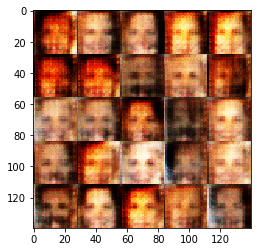

Epoch 1/1... Discriminator Loss: 1.3092... Generator Loss: 0.6740
Epoch 1/1... Discriminator Loss: 1.4648... Generator Loss: 0.5832
Epoch 1/1... Discriminator Loss: 1.3755... Generator Loss: 0.7837
Epoch 1/1... Discriminator Loss: 1.3568... Generator Loss: 0.8858
Epoch 1/1... Discriminator Loss: 1.4580... Generator Loss: 1.4252
Epoch 1/1... Discriminator Loss: 1.4739... Generator Loss: 0.9725
Epoch 1/1... Discriminator Loss: 1.2501... Generator Loss: 0.8566
Epoch 1/1... Discriminator Loss: 1.3460... Generator Loss: 0.9200
Epoch 1/1... Discriminator Loss: 1.4085... Generator Loss: 0.8215
Epoch 1/1... Discriminator Loss: 1.3675... Generator Loss: 0.8693


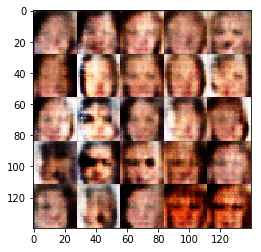

Epoch 1/1... Discriminator Loss: 1.3525... Generator Loss: 1.0195
Epoch 1/1... Discriminator Loss: 1.2570... Generator Loss: 1.0304
Epoch 1/1... Discriminator Loss: 1.3540... Generator Loss: 1.1420
Epoch 1/1... Discriminator Loss: 1.3839... Generator Loss: 1.0022
Epoch 1/1... Discriminator Loss: 1.3461... Generator Loss: 1.0050
Epoch 1/1... Discriminator Loss: 1.2640... Generator Loss: 0.8527
Epoch 1/1... Discriminator Loss: 1.3667... Generator Loss: 0.9663
Epoch 1/1... Discriminator Loss: 1.3186... Generator Loss: 0.6955
Epoch 1/1... Discriminator Loss: 1.2768... Generator Loss: 0.9023
Epoch 1/1... Discriminator Loss: 1.3468... Generator Loss: 0.9684


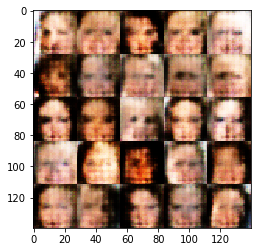

Epoch 1/1... Discriminator Loss: 1.4052... Generator Loss: 0.7844
Epoch 1/1... Discriminator Loss: 1.3169... Generator Loss: 0.8133
Epoch 1/1... Discriminator Loss: 1.3060... Generator Loss: 0.8938
Epoch 1/1... Discriminator Loss: 1.6019... Generator Loss: 0.5103
Epoch 1/1... Discriminator Loss: 1.3655... Generator Loss: 0.8572
Epoch 1/1... Discriminator Loss: 1.3088... Generator Loss: 0.8178
Epoch 1/1... Discriminator Loss: 1.2824... Generator Loss: 1.0233
Epoch 1/1... Discriminator Loss: 1.3682... Generator Loss: 1.1476
Epoch 1/1... Discriminator Loss: 1.3436... Generator Loss: 0.9251
Epoch 1/1... Discriminator Loss: 1.2983... Generator Loss: 1.0241


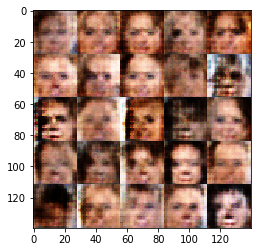

Epoch 1/1... Discriminator Loss: 1.3046... Generator Loss: 0.8357
Epoch 1/1... Discriminator Loss: 1.3311... Generator Loss: 0.7067
Epoch 1/1... Discriminator Loss: 1.2895... Generator Loss: 0.9178
Epoch 1/1... Discriminator Loss: 1.3187... Generator Loss: 1.0623
Epoch 1/1... Discriminator Loss: 1.2839... Generator Loss: 0.9503
Epoch 1/1... Discriminator Loss: 1.3301... Generator Loss: 0.9136
Epoch 1/1... Discriminator Loss: 1.2154... Generator Loss: 0.9324
Epoch 1/1... Discriminator Loss: 1.2700... Generator Loss: 0.8574
Epoch 1/1... Discriminator Loss: 1.3234... Generator Loss: 0.6808
Epoch 1/1... Discriminator Loss: 1.3668... Generator Loss: 0.7225


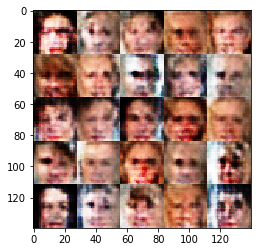

Epoch 1/1... Discriminator Loss: 1.3718... Generator Loss: 0.6009
Epoch 1/1... Discriminator Loss: 1.4293... Generator Loss: 0.6922
Epoch 1/1... Discriminator Loss: 1.2567... Generator Loss: 0.9908
Epoch 1/1... Discriminator Loss: 1.4959... Generator Loss: 1.3679
Epoch 1/1... Discriminator Loss: 1.2917... Generator Loss: 0.9507
Epoch 1/1... Discriminator Loss: 1.3564... Generator Loss: 0.7098
Epoch 1/1... Discriminator Loss: 1.1960... Generator Loss: 1.1355
Epoch 1/1... Discriminator Loss: 1.5223... Generator Loss: 1.2639
Epoch 1/1... Discriminator Loss: 1.3810... Generator Loss: 0.7500
Epoch 1/1... Discriminator Loss: 1.2997... Generator Loss: 0.9507


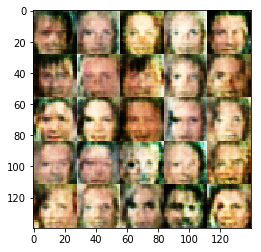

Epoch 1/1... Discriminator Loss: 1.4109... Generator Loss: 1.0545
Epoch 1/1... Discriminator Loss: 1.3573... Generator Loss: 0.9061
Epoch 1/1... Discriminator Loss: 1.3179... Generator Loss: 0.8826
Epoch 1/1... Discriminator Loss: 1.2980... Generator Loss: 0.7592
Epoch 1/1... Discriminator Loss: 1.3438... Generator Loss: 0.9917
Epoch 1/1... Discriminator Loss: 1.3702... Generator Loss: 0.9550
Epoch 1/1... Discriminator Loss: 1.2964... Generator Loss: 1.0750
Epoch 1/1... Discriminator Loss: 1.3090... Generator Loss: 0.7665
Epoch 1/1... Discriminator Loss: 1.3119... Generator Loss: 0.9402
Epoch 1/1... Discriminator Loss: 1.4236... Generator Loss: 0.7923


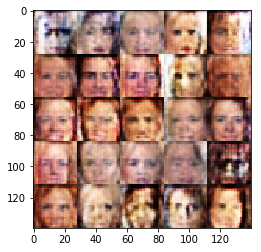

Epoch 1/1... Discriminator Loss: 1.3643... Generator Loss: 0.7393
Epoch 1/1... Discriminator Loss: 1.3389... Generator Loss: 0.6626
Epoch 1/1... Discriminator Loss: 1.3748... Generator Loss: 0.7405
Epoch 1/1... Discriminator Loss: 1.3578... Generator Loss: 0.8005
Epoch 1/1... Discriminator Loss: 1.3209... Generator Loss: 0.8552
Epoch 1/1... Discriminator Loss: 1.2783... Generator Loss: 0.8186
Epoch 1/1... Discriminator Loss: 1.4548... Generator Loss: 0.6495
Epoch 1/1... Discriminator Loss: 1.2082... Generator Loss: 1.0359
Epoch 1/1... Discriminator Loss: 1.4395... Generator Loss: 0.8563
Epoch 1/1... Discriminator Loss: 1.4073... Generator Loss: 0.6423


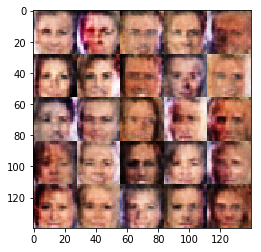

Epoch 1/1... Discriminator Loss: 1.4351... Generator Loss: 0.8050
Epoch 1/1... Discriminator Loss: 1.3975... Generator Loss: 0.7806
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.7492
Epoch 1/1... Discriminator Loss: 1.3282... Generator Loss: 0.8890
Epoch 1/1... Discriminator Loss: 1.3210... Generator Loss: 0.7615
Epoch 1/1... Discriminator Loss: 1.3001... Generator Loss: 0.7590
Epoch 1/1... Discriminator Loss: 1.3296... Generator Loss: 0.7829
Epoch 1/1... Discriminator Loss: 1.3576... Generator Loss: 0.8336
Epoch 1/1... Discriminator Loss: 1.3620... Generator Loss: 0.6882
Epoch 1/1... Discriminator Loss: 1.3852... Generator Loss: 0.8628


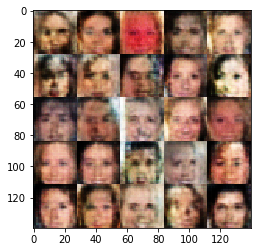

Epoch 1/1... Discriminator Loss: 1.3681... Generator Loss: 0.8210
Epoch 1/1... Discriminator Loss: 1.3539... Generator Loss: 0.8653
Epoch 1/1... Discriminator Loss: 1.3273... Generator Loss: 0.7872
Epoch 1/1... Discriminator Loss: 1.3649... Generator Loss: 0.7969
Epoch 1/1... Discriminator Loss: 1.3324... Generator Loss: 0.8040
Epoch 1/1... Discriminator Loss: 1.3558... Generator Loss: 0.8030
Epoch 1/1... Discriminator Loss: 1.3508... Generator Loss: 0.9199
Epoch 1/1... Discriminator Loss: 1.3934... Generator Loss: 0.8477
Epoch 1/1... Discriminator Loss: 1.3122... Generator Loss: 0.8308
Epoch 1/1... Discriminator Loss: 1.3888... Generator Loss: 0.8206


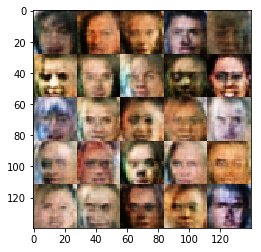

Epoch 1/1... Discriminator Loss: 1.3853... Generator Loss: 0.8612
Epoch 1/1... Discriminator Loss: 1.3234... Generator Loss: 0.8452
Epoch 1/1... Discriminator Loss: 1.3793... Generator Loss: 0.8398
Epoch 1/1... Discriminator Loss: 1.4060... Generator Loss: 0.7204
Epoch 1/1... Discriminator Loss: 1.3028... Generator Loss: 0.8332
Epoch 1/1... Discriminator Loss: 1.3665... Generator Loss: 0.8271
Epoch 1/1... Discriminator Loss: 1.3243... Generator Loss: 0.7994
Epoch 1/1... Discriminator Loss: 1.3611... Generator Loss: 0.8048
Epoch 1/1... Discriminator Loss: 1.3226... Generator Loss: 0.8288
Epoch 1/1... Discriminator Loss: 1.3485... Generator Loss: 0.7984


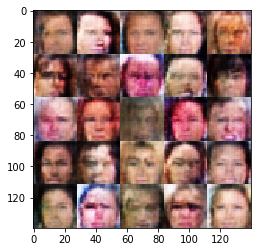

Epoch 1/1... Discriminator Loss: 1.3297... Generator Loss: 0.8215
Epoch 1/1... Discriminator Loss: 1.3461... Generator Loss: 0.8409
Epoch 1/1... Discriminator Loss: 1.3464... Generator Loss: 0.8134
Epoch 1/1... Discriminator Loss: 1.3633... Generator Loss: 0.8919
Epoch 1/1... Discriminator Loss: 1.3505... Generator Loss: 0.7167
Epoch 1/1... Discriminator Loss: 1.3438... Generator Loss: 0.8171
Epoch 1/1... Discriminator Loss: 1.3672... Generator Loss: 0.8049
Epoch 1/1... Discriminator Loss: 1.3986... Generator Loss: 0.8023
Epoch 1/1... Discriminator Loss: 1.3366... Generator Loss: 0.8700
Epoch 1/1... Discriminator Loss: 1.3564... Generator Loss: 0.8167


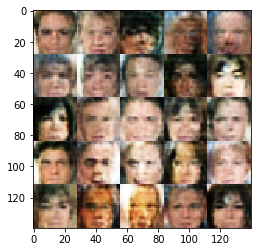

Epoch 1/1... Discriminator Loss: 1.3217... Generator Loss: 0.8186
Epoch 1/1... Discriminator Loss: 1.3860... Generator Loss: 0.8509
Epoch 1/1... Discriminator Loss: 1.3472... Generator Loss: 0.7481
Epoch 1/1... Discriminator Loss: 1.3942... Generator Loss: 0.8868
Epoch 1/1... Discriminator Loss: 1.3236... Generator Loss: 0.8846
Epoch 1/1... Discriminator Loss: 1.3723... Generator Loss: 0.8471
Epoch 1/1... Discriminator Loss: 1.2919... Generator Loss: 0.9309
Epoch 1/1... Discriminator Loss: 1.3188... Generator Loss: 0.7686
Epoch 1/1... Discriminator Loss: 1.3276... Generator Loss: 0.7721
Epoch 1/1... Discriminator Loss: 1.3788... Generator Loss: 0.9078


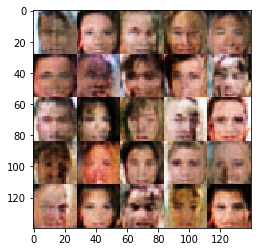

Epoch 1/1... Discriminator Loss: 1.3620... Generator Loss: 0.9109
Epoch 1/1... Discriminator Loss: 1.3544... Generator Loss: 0.7294
Epoch 1/1... Discriminator Loss: 1.3417... Generator Loss: 0.7768
Epoch 1/1... Discriminator Loss: 1.3879... Generator Loss: 0.8276
Epoch 1/1... Discriminator Loss: 1.3392... Generator Loss: 0.9187
Epoch 1/1... Discriminator Loss: 1.3809... Generator Loss: 0.8565
Epoch 1/1... Discriminator Loss: 1.3725... Generator Loss: 0.8278
Epoch 1/1... Discriminator Loss: 1.3265... Generator Loss: 0.9203
Epoch 1/1... Discriminator Loss: 1.3546... Generator Loss: 0.8702
Epoch 1/1... Discriminator Loss: 1.3369... Generator Loss: 0.8489


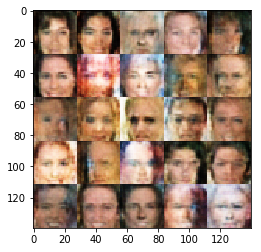

Epoch 1/1... Discriminator Loss: 1.3421... Generator Loss: 0.8478
Epoch 1/1... Discriminator Loss: 1.3542... Generator Loss: 0.6984
Epoch 1/1... Discriminator Loss: 1.3852... Generator Loss: 0.7421
Epoch 1/1... Discriminator Loss: 1.2745... Generator Loss: 0.9585
Epoch 1/1... Discriminator Loss: 1.3873... Generator Loss: 0.7211
Epoch 1/1... Discriminator Loss: 1.3506... Generator Loss: 0.8471
Epoch 1/1... Discriminator Loss: 1.4013... Generator Loss: 0.6797
Epoch 1/1... Discriminator Loss: 1.4104... Generator Loss: 0.6685
Epoch 1/1... Discriminator Loss: 1.3387... Generator Loss: 0.7259
Epoch 1/1... Discriminator Loss: 1.3456... Generator Loss: 0.8117


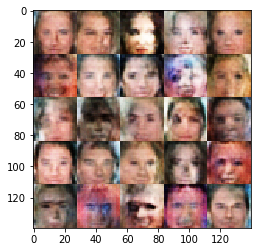

Epoch 1/1... Discriminator Loss: 1.3556... Generator Loss: 0.7750
Epoch 1/1... Discriminator Loss: 1.3300... Generator Loss: 0.8601
Epoch 1/1... Discriminator Loss: 1.2797... Generator Loss: 0.8407
Epoch 1/1... Discriminator Loss: 1.3390... Generator Loss: 0.8289
Epoch 1/1... Discriminator Loss: 1.3399... Generator Loss: 0.7493
Epoch 1/1... Discriminator Loss: 1.3291... Generator Loss: 0.6965
Epoch 1/1... Discriminator Loss: 1.3206... Generator Loss: 0.8360
Epoch 1/1... Discriminator Loss: 1.4112... Generator Loss: 0.7016
Epoch 1/1... Discriminator Loss: 1.3686... Generator Loss: 0.8011
Epoch 1/1... Discriminator Loss: 1.3866... Generator Loss: 0.8172


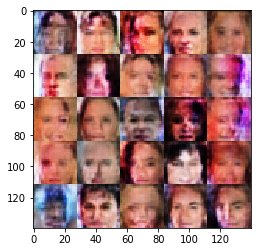

Epoch 1/1... Discriminator Loss: 1.3657... Generator Loss: 0.8026
Epoch 1/1... Discriminator Loss: 1.3609... Generator Loss: 0.7508
Epoch 1/1... Discriminator Loss: 1.3869... Generator Loss: 0.7912
Epoch 1/1... Discriminator Loss: 1.3589... Generator Loss: 0.8158
Epoch 1/1... Discriminator Loss: 1.4012... Generator Loss: 0.7246
Epoch 1/1... Discriminator Loss: 1.3413... Generator Loss: 0.7810
Epoch 1/1... Discriminator Loss: 1.3699... Generator Loss: 0.7569
Epoch 1/1... Discriminator Loss: 1.3294... Generator Loss: 0.7863
Epoch 1/1... Discriminator Loss: 1.3912... Generator Loss: 0.7630
Epoch 1/1... Discriminator Loss: 1.3926... Generator Loss: 0.8574


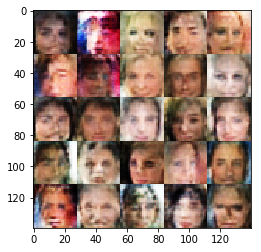

Epoch 1/1... Discriminator Loss: 1.3348... Generator Loss: 0.8358
Epoch 1/1... Discriminator Loss: 1.3479... Generator Loss: 0.8046
Epoch 1/1... Discriminator Loss: 1.3429... Generator Loss: 0.8311
Epoch 1/1... Discriminator Loss: 1.2956... Generator Loss: 0.7472
Epoch 1/1... Discriminator Loss: 1.3068... Generator Loss: 0.8384
Epoch 1/1... Discriminator Loss: 1.3872... Generator Loss: 0.8575
Epoch 1/1... Discriminator Loss: 1.3061... Generator Loss: 0.7632
Epoch 1/1... Discriminator Loss: 1.3593... Generator Loss: 0.7637
Epoch 1/1... Discriminator Loss: 1.3169... Generator Loss: 0.8681
Epoch 1/1... Discriminator Loss: 1.3252... Generator Loss: 0.8615


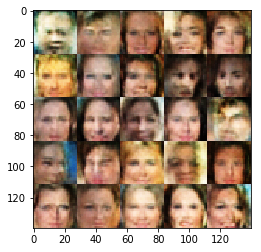

Epoch 1/1... Discriminator Loss: 1.3364... Generator Loss: 0.8682
Epoch 1/1... Discriminator Loss: 1.3942... Generator Loss: 0.8018
Epoch 1/1... Discriminator Loss: 1.3793... Generator Loss: 0.7105
Epoch 1/1... Discriminator Loss: 1.3477... Generator Loss: 0.8263
Epoch 1/1... Discriminator Loss: 1.3969... Generator Loss: 0.6745
Epoch 1/1... Discriminator Loss: 1.3805... Generator Loss: 0.8487
Epoch 1/1... Discriminator Loss: 1.3251... Generator Loss: 0.8602
Epoch 1/1... Discriminator Loss: 1.3154... Generator Loss: 0.8108
Epoch 1/1... Discriminator Loss: 1.3742... Generator Loss: 0.8500
Epoch 1/1... Discriminator Loss: 1.3668... Generator Loss: 0.8398


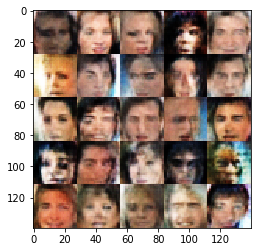

Epoch 1/1... Discriminator Loss: 1.3596... Generator Loss: 0.9186
Epoch 1/1... Discriminator Loss: 1.3687... Generator Loss: 0.7660
Epoch 1/1... Discriminator Loss: 1.3896... Generator Loss: 0.7944
Epoch 1/1... Discriminator Loss: 1.3955... Generator Loss: 0.7018
Epoch 1/1... Discriminator Loss: 1.3700... Generator Loss: 0.8075
Epoch 1/1... Discriminator Loss: 1.3168... Generator Loss: 0.8569
Epoch 1/1... Discriminator Loss: 1.3849... Generator Loss: 0.7114
Epoch 1/1... Discriminator Loss: 1.3778... Generator Loss: 0.7577
Epoch 1/1... Discriminator Loss: 1.3686... Generator Loss: 0.7348
Epoch 1/1... Discriminator Loss: 1.3725... Generator Loss: 0.7619


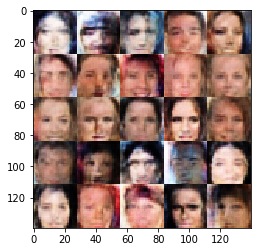

Epoch 1/1... Discriminator Loss: 1.4352... Generator Loss: 0.7403
Epoch 1/1... Discriminator Loss: 1.3137... Generator Loss: 0.9425
Epoch 1/1... Discriminator Loss: 1.3900... Generator Loss: 0.7754
Epoch 1/1... Discriminator Loss: 1.3323... Generator Loss: 0.8401
Epoch 1/1... Discriminator Loss: 1.3737... Generator Loss: 0.9192
Epoch 1/1... Discriminator Loss: 1.3758... Generator Loss: 0.7462
Epoch 1/1... Discriminator Loss: 1.3736... Generator Loss: 0.8526
Epoch 1/1... Discriminator Loss: 1.3454... Generator Loss: 0.8898
Epoch 1/1... Discriminator Loss: 1.3084... Generator Loss: 0.8614
Epoch 1/1... Discriminator Loss: 1.3368... Generator Loss: 0.8742


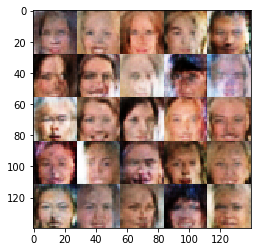

Epoch 1/1... Discriminator Loss: 1.3812... Generator Loss: 0.8136
Epoch 1/1... Discriminator Loss: 1.3543... Generator Loss: 0.7836
Epoch 1/1... Discriminator Loss: 1.3488... Generator Loss: 0.8452
Epoch 1/1... Discriminator Loss: 1.3836... Generator Loss: 0.8177
Epoch 1/1... Discriminator Loss: 1.3921... Generator Loss: 0.8713
Epoch 1/1... Discriminator Loss: 1.3340... Generator Loss: 0.8037
Epoch 1/1... Discriminator Loss: 1.3962... Generator Loss: 0.8647
Epoch 1/1... Discriminator Loss: 1.3841... Generator Loss: 0.9238
Epoch 1/1... Discriminator Loss: 1.3799... Generator Loss: 0.7830
Epoch 1/1... Discriminator Loss: 1.3464... Generator Loss: 0.8386


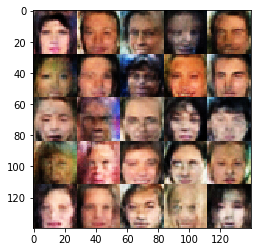

Epoch 1/1... Discriminator Loss: 1.3417... Generator Loss: 0.8745
Epoch 1/1... Discriminator Loss: 1.3794... Generator Loss: 0.8107
Epoch 1/1... Discriminator Loss: 1.4100... Generator Loss: 0.7579
Epoch 1/1... Discriminator Loss: 1.3753... Generator Loss: 0.8020
Epoch 1/1... Discriminator Loss: 1.3790... Generator Loss: 0.7298
Epoch 1/1... Discriminator Loss: 1.4167... Generator Loss: 1.0322
Epoch 1/1... Discriminator Loss: 1.3262... Generator Loss: 0.8707
Epoch 1/1... Discriminator Loss: 1.3544... Generator Loss: 0.8019
Epoch 1/1... Discriminator Loss: 1.3758... Generator Loss: 0.8482
Epoch 1/1... Discriminator Loss: 1.3489... Generator Loss: 0.7414


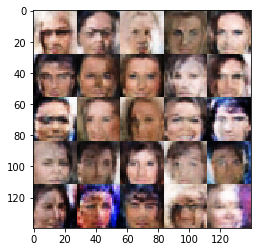

Epoch 1/1... Discriminator Loss: 1.3236... Generator Loss: 0.8356
Epoch 1/1... Discriminator Loss: 1.3795... Generator Loss: 0.6853
Epoch 1/1... Discriminator Loss: 1.3609... Generator Loss: 0.7699
Epoch 1/1... Discriminator Loss: 1.4026... Generator Loss: 0.7525
Epoch 1/1... Discriminator Loss: 1.3748... Generator Loss: 0.7874
Epoch 1/1... Discriminator Loss: 1.3221... Generator Loss: 0.7350
Epoch 1/1... Discriminator Loss: 1.3872... Generator Loss: 0.7287
Epoch 1/1... Discriminator Loss: 1.4104... Generator Loss: 0.7985
Epoch 1/1... Discriminator Loss: 1.4016... Generator Loss: 0.9165
Epoch 1/1... Discriminator Loss: 1.3502... Generator Loss: 0.7364


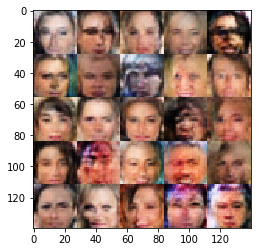

Epoch 1/1... Discriminator Loss: 1.3547... Generator Loss: 0.8620
Epoch 1/1... Discriminator Loss: 1.3436... Generator Loss: 0.8082
Epoch 1/1... Discriminator Loss: 1.3365... Generator Loss: 0.8014
Epoch 1/1... Discriminator Loss: 1.3838... Generator Loss: 0.8253
Epoch 1/1... Discriminator Loss: 1.3274... Generator Loss: 0.8562
Epoch 1/1... Discriminator Loss: 1.3341... Generator Loss: 0.7667
Epoch 1/1... Discriminator Loss: 1.3198... Generator Loss: 0.9022
Epoch 1/1... Discriminator Loss: 1.3354... Generator Loss: 0.7631
Epoch 1/1... Discriminator Loss: 1.3808... Generator Loss: 0.7396
Epoch 1/1... Discriminator Loss: 1.3000... Generator Loss: 0.7775


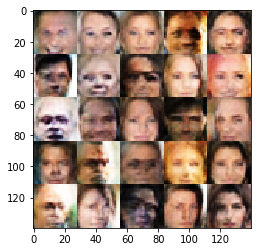

Epoch 1/1... Discriminator Loss: 1.3259... Generator Loss: 0.8112
Epoch 1/1... Discriminator Loss: 1.3548... Generator Loss: 0.8297
Epoch 1/1... Discriminator Loss: 1.3651... Generator Loss: 0.7823
Epoch 1/1... Discriminator Loss: 1.3706... Generator Loss: 0.7362
Epoch 1/1... Discriminator Loss: 1.3558... Generator Loss: 0.7352
Epoch 1/1... Discriminator Loss: 1.3866... Generator Loss: 0.8548
Epoch 1/1... Discriminator Loss: 1.3577... Generator Loss: 0.7972
Epoch 1/1... Discriminator Loss: 1.3523... Generator Loss: 0.7169
Epoch 1/1... Discriminator Loss: 1.3287... Generator Loss: 0.8930
Epoch 1/1... Discriminator Loss: 1.3235... Generator Loss: 0.8653


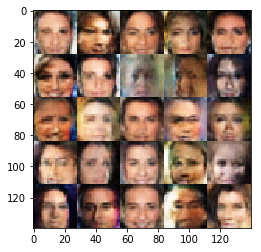

Epoch 1/1... Discriminator Loss: 1.3161... Generator Loss: 0.8850
Epoch 1/1... Discriminator Loss: 1.3919... Generator Loss: 0.7021
Epoch 1/1... Discriminator Loss: 1.3563... Generator Loss: 0.8218
Epoch 1/1... Discriminator Loss: 1.3356... Generator Loss: 0.8052
Epoch 1/1... Discriminator Loss: 1.3625... Generator Loss: 0.8066
Epoch 1/1... Discriminator Loss: 1.3656... Generator Loss: 0.7732
Epoch 1/1... Discriminator Loss: 1.3913... Generator Loss: 0.7945
Epoch 1/1... Discriminator Loss: 1.3590... Generator Loss: 0.8374
Epoch 1/1... Discriminator Loss: 1.3403... Generator Loss: 0.9178
Epoch 1/1... Discriminator Loss: 1.3809... Generator Loss: 0.8338


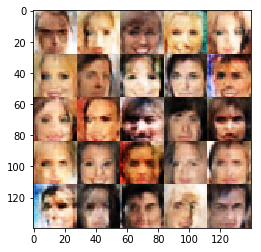

Epoch 1/1... Discriminator Loss: 1.3410... Generator Loss: 0.8491
Epoch 1/1... Discriminator Loss: 1.4109... Generator Loss: 0.8407
Epoch 1/1... Discriminator Loss: 1.3862... Generator Loss: 0.7479
Epoch 1/1... Discriminator Loss: 1.3623... Generator Loss: 0.8161
Epoch 1/1... Discriminator Loss: 1.3769... Generator Loss: 0.8336
Epoch 1/1... Discriminator Loss: 1.3839... Generator Loss: 0.8302
Epoch 1/1... Discriminator Loss: 1.3666... Generator Loss: 0.7219
Epoch 1/1... Discriminator Loss: 1.4058... Generator Loss: 0.7911
Epoch 1/1... Discriminator Loss: 1.3391... Generator Loss: 0.7947
Epoch 1/1... Discriminator Loss: 1.3726... Generator Loss: 0.7214


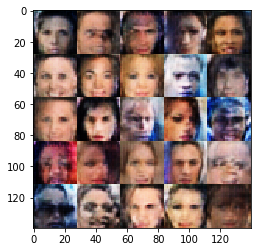

Epoch 1/1... Discriminator Loss: 1.3612... Generator Loss: 0.7975
Epoch 1/1... Discriminator Loss: 1.3479... Generator Loss: 0.7635
Epoch 1/1... Discriminator Loss: 1.3482... Generator Loss: 0.7879
Epoch 1/1... Discriminator Loss: 1.3541... Generator Loss: 0.7926
Epoch 1/1... Discriminator Loss: 1.3710... Generator Loss: 0.9099
Epoch 1/1... Discriminator Loss: 1.3489... Generator Loss: 0.8069


In [45]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.